In [1]:
#https://susanqq.github.io/UTKFace/
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
data_path = '/Users/daniehao/Desktop/facedata'

#[age]_[gender]_[race]_[date&time].jpg

def load_images_from_folder(folder):
    images = []
    age_group=[]
    count0 = 0
    count2 = 0
    count1 = 0
    female = {'0':0, '1':0, '2':0}
    male = {'0':0, '1':0, '2':0}
    for filename in folder:
        img = cv2.imread(filename)
        filename = filename.split('_')
        temp = filename[0]
        temp = temp.split('/')
        try:
            age = int(temp[-1])
            gender_index = int(filename[1])
            #race_index = int(filename[2])
        except:
            continue
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img =cv2.resize(img,(128,128))
            if age<=15 and count0 <= 3500:
                count0 += 1
                age_group += [0]
                images.append(img)
                if gender_index == 0:
                    male['0'] += 1
                else:
                    female['0'] += 1
            elif age > 45 and count1 <= 3500:
                count1 += 1
                age_group+=[2]
                images.append(img)
                if gender_index == 0:
                    male['2'] += 1
                else:
                    female['2'] += 1
            elif age > 15 and age <= 45 and count2 <= 3500:
                count2 += 1
                age_group += [1]
                images.append(img)
                if gender_index == 0:
                    male['1'] += 1
                else:
                    female['1'] += 1
    return images,age_group,female,male

In [2]:
import os
import random
import sys
dir_name=sys.argv[1]
files = []
img_path = []
for filename in os.listdir(data_path):
    files.append(filename)
# shuffle list
random.shuffle(files)
for item in files:
    img_path.append(os.path.join(data_path,item))

In [3]:
face_data, ages, female_count, male_count=load_images_from_folder(img_path)

In [4]:
print(female_count)

{'0': 1844, '1': 1797, '2': 1277}


In [5]:
print(male_count)

{'0': 1657, '1': 1704, '2': 2224}


In [6]:
img_data = np.array(face_data)
ages = np.array(ages)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

(10503, 128, 128)

In [7]:
img_data = img_data/255
#img_data = img_data.reshape([7271, 128*128])
img_data = img_data.reshape([10503, 128*128])
img_data.shape

(10503, 16384)

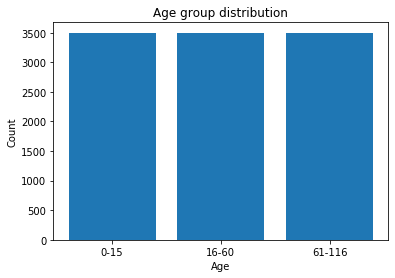

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

c = Counter(ages)
plt.bar(c.keys(), c.values())
plt.xticks(np.arange(3),['0-15','16-60','61-116'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title("Age group distribution")
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
import sklearn
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(img_data, ages, test_size=0.25)

print(len(X_train))
print(len(X_test))

7877
2626


In [199]:
simg_data = img_data[:3000]
sages = ages[:3000]

In [200]:
#from sklearn.preprocessing import label_binarize
#y_train = label_binarize(y_train, classes=[0, 1, 2])
#y_test = label_binarize(y_test, classes=[0, 1, 2])

In [10]:
X_test.shape

(2626, 16384)

In [11]:
X_train.shape

(7877, 16384)

In [132]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Activation
import time
from keras.utils import np_utils
import keras.callbacks as cb
from keras.optimizers import RMSprop
from keras import regularizers
y_train = np_utils.to_categorical(y_train, 3)
y_test = np_utils.to_categorical(y_test, 3)
X_train = np.reshape(X_train, (6752, 128, 128, 1))
X_test = np.reshape(X_test, (2251, 128, 128, 1))
def init_model():
    start_time = time.time()
    print("compiling model")
    model = Sequential()
    model.add(Conv2D(96, kernel_size=(11,11), strides=(4, 4), padding='valid', activation = 'relu', input_shape=(128, 128,1)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, padding = 'same', kernel_size=(5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, padding = 'same', kernel_size=(3,3), activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, padding = 'same', kernel_size=(3,3), activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, padding = 'same', kernel_size=(3,3), activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))
    model.summary()
    rms = RMSprop()
    model.compile(loss = 'categorical_crossentropy', optimizer = rms, metrics=['accuracy'])
    print("Model finished" + format(time.time() - start_time))
    return model

model = init_model()

compiling model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 30, 30, 96)        11712     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 96)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 14, 14, 96)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 14, 14, 128)       307328    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 4, 4, 128)         14758

In [133]:
history = model.fit(X_train, y_train, batch_size = 512, epochs = 20)
score = model.evaluate(X_test, y_test, verbose=1)
print("\nNetwork's test loss and accuracy: " + format(score))

Epoch 1/20
6752/6752 [==============================] - 43s 6ms/step - loss: 1.8201 - acc: 0.3328
Epoch 2/20
6752/6752 [==============================] - 43s 6ms/step - loss: 1.3468 - acc: 0.3415
Epoch 3/20
6752/6752 [==============================] - 42s 6ms/step - loss: 1.1952 - acc: 0.3335
Epoch 4/20
6752/6752 [==============================] - 44s 7ms/step - loss: 1.2003 - acc: 0.3452
Epoch 5/20
6752/6752 [==============================] - 45s 7ms/step - loss: 1.1165 - acc: 0.4313
Epoch 6/20
6752/6752 [==============================] - 43s 6ms/step - loss: 1.0942 - acc: 0.4191
Epoch 7/20
6752/6752 [==============================] - 43s 6ms/step - loss: 1.1227 - acc: 0.4076
Epoch 8/20
6752/6752 [==============================] - 43s 6ms/step - loss: 1.0912 - acc: 0.4416
Epoch 9/20
6752/6752 [==============================] - 43s 6ms/step - loss: 1.0838 - acc: 0.4523
Epoch 10/20
6752/6752 [==============================] - 43s 6ms/step - loss: 1.0759 - acc: 0.4390
Epoch 11/20
6752/67

In [134]:
history = model.fit(X_train, y_train, batch_size = 64, epochs = 20)
score = model.evaluate(X_test, y_test, verbose=1)
print("\nNetwork's test loss and accuracy: " + format(score))

Epoch 1/20
6752/6752 [==============================] - 47s 7ms/step - loss: 1.0350 - acc: 0.4772
Epoch 2/20
6752/6752 [==============================] - 50s 7ms/step - loss: 1.0263 - acc: 0.4858
Epoch 3/20
6752/6752 [==============================] - 50s 7ms/step - loss: 1.0158 - acc: 0.4973
Epoch 4/20
6752/6752 [==============================] - 54s 8ms/step - loss: 1.0017 - acc: 0.5098
Epoch 5/20
6752/6752 [==============================] - 54s 8ms/step - loss: 0.9953 - acc: 0.5151
Epoch 6/20
6752/6752 [==============================] - 54s 8ms/step - loss: 0.9881 - acc: 0.5280
Epoch 7/20
6752/6752 [==============================] - 56s 8ms/step - loss: 0.9855 - acc: 0.5320
Epoch 8/20
6752/6752 [==============================] - 55s 8ms/step - loss: 0.9817 - acc: 0.5342
Epoch 9/20
6752/6752 [==============================] - 55s 8ms/step - loss: 0.9782 - acc: 0.5367
Epoch 10/20
6752/6752 [==============================] - 59s 9ms/step - loss: 0.9768 - acc: 0.5354
Epoch 11/20
6752/67

In [18]:
history = model.fit(X_train, y_train, batch_size = 1024, epochs = 50)
score = model.evaluate(X_test, y_test, verbose=1)
print("\nNetwork's test loss and accuracy: " + format(score))

Epoch 1/50
7877/7877 [==============================] - 52s 7ms/step - loss: 2.0845 - acc: 0.3319
Epoch 2/50
7877/7877 [==============================] - 53s 7ms/step - loss: 2.0814 - acc: 0.3393
Epoch 3/50
7877/7877 [==============================] - 60s 8ms/step - loss: 2.0783 - acc: 0.3291
Epoch 4/50
7877/7877 [==============================] - 48s 6ms/step - loss: 2.0750 - acc: 0.3369
Epoch 5/50
7877/7877 [==============================] - 50s 6ms/step - loss: 2.0719 - acc: 0.3368
Epoch 6/50
7877/7877 [==============================] - 53s 7ms/step - loss: 2.0689 - acc: 0.3345
Epoch 7/50
7877/7877 [==============================] - 50s 6ms/step - loss: 2.0658 - acc: 0.3363
Epoch 8/50
7877/7877 [==============================] - 51s 7ms/step - loss: 2.0626 - acc: 0.3399
Epoch 9/50
7877/7877 [==============================] - 50s 6ms/step - loss: 2.0596 - acc: 0.3307
Epoch 10/50
7877/7877 [==============================] - 50s 6ms/step - loss: 2.0565 - acc: 0.3354
Epoch 11/50
7877/78

KeyboardInterrupt: 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Activation
import time
from keras.utils import np_utils
import keras.callbacks as cb
from keras.optimizers import RMSprop
from keras import regularizers
from keras.optimizers import SGD
y_train = np_utils.to_categorical(y_train, 3)
y_test = np_utils.to_categorical(y_test, 3)
X_train = np.reshape(X_train, (6752, 128, 128, 1))
X_test = np.reshape(X_test, (2251, 128, 128, 1))
def init_model():
    start_time = time.time()
    print("compiling model")
    model = Sequential()
    model.add(Conv2D(96, kernel_size=(11,11), strides=(4, 4), padding='valid', activation = 'relu', input_shape=(128, 128,1)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, padding = 'same', kernel_size=(5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, padding = 'same', kernel_size=(3,3), activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, padding = 'same', kernel_size=(3,3), activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, padding = 'same', kernel_size=(3,3), activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))
    model.summary()
    rms = RMSprop()
    model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
    print("Model finished" + format(time.time() - start_time))
    return model

model = init_model()

In [135]:
history = model.fit(X_train, y_train, batch_size = 64, epochs = 20)
score = model.evaluate(X_test, y_test, verbose=1)
print("\nNetwork's test loss and accuracy: " + format(score))

Epoch 1/20
6752/6752 [==============================] - 48s 7ms/step - loss: 0.9419 - acc: 0.5619
Epoch 2/20
6752/6752 [==============================] - 49s 7ms/step - loss: 0.9350 - acc: 0.5637
Epoch 3/20
6752/6752 [==============================] - 55s 8ms/step - loss: 0.9350 - acc: 0.5641
Epoch 4/20
6752/6752 [==============================] - 55s 8ms/step - loss: 0.9349 - acc: 0.5635
Epoch 5/20
6752/6752 [==============================] - 54s 8ms/step - loss: 0.9293 - acc: 0.5702
Epoch 6/20
6752/6752 [==============================] - 55s 8ms/step - loss: 0.9266 - acc: 0.5695
Epoch 7/20
6752/6752 [==============================] - 56s 8ms/step - loss: 0.9227 - acc: 0.5708
Epoch 8/20
6752/6752 [==============================] - 54s 8ms/step - loss: 0.9267 - acc: 0.5714
Epoch 9/20
6752/6752 [==============================] - 51s 8ms/step - loss: 0.9227 - acc: 0.5699
Epoch 10/20
6752/6752 [==============================] - 55s 8ms/step - loss: 0.9256 - acc: 0.5772
Epoch 11/20
6752/67

In [25]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(img_data, ages, test_size=0.25)

In [26]:
X_train.shape

(7877, 16384)

In [27]:
X_test.shape

(2626, 16384)

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Activation
import time
from keras.utils import np_utils
import keras.callbacks as cb
from keras.optimizers import RMSprop
from keras import regularizers
from keras.optimizers import SGD
y_train = np_utils.to_categorical(y_train, 3)
y_test = np_utils.to_categorical(y_test, 3)
X_train = np.reshape(X_train, (7877, 128, 128, 1))
X_test = np.reshape(X_test, (2626, 128, 128, 1))
def init_model():
    start_time = time.time()
    print("compiling model")
    model = Sequential()
    model.add(Conv2D(96, kernel_size=(11,11), strides=(4, 4), padding='valid', activation = 'relu', input_shape=(128, 128,1)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, padding = 'same', kernel_size=(5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, padding = 'same', kernel_size=(3,3), activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, padding = 'same', kernel_size=(3,3), activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, padding = 'same', kernel_size=(3,3), activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))
    model.summary()
    rms = RMSprop()
    model.compile(loss = 'categorical_crossentropy', optimizer = rms, metrics=['accuracy'])
    print("Model finished" + format(time.time() - start_time))
    return model

model = init_model()


compiling model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 30, 30, 96)        11712     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 96)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 14, 14, 96)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 128)       307328    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 128)         14758

In [29]:
history = model.fit(X_train, y_train, batch_size = 512, epochs = 20)
score = model.evaluate(X_test, y_test, verbose=1)
print("\nNetwork's test loss and accuracy: " + format(score))

Epoch 1/20
7877/7877 [==============================] - 48s 6ms/step - loss: 1.7739 - acc: 0.3282
Epoch 2/20
7877/7877 [==============================] - 47s 6ms/step - loss: 1.3012 - acc: 0.3364
Epoch 3/20
7877/7877 [==============================] - 47s 6ms/step - loss: 1.1670 - acc: 0.3368
Epoch 4/20
7877/7877 [==============================] - 48s 6ms/step - loss: 1.1296 - acc: 0.3511
Epoch 5/20
7877/7877 [==============================] - 50s 6ms/step - loss: 1.1879 - acc: 0.3467
Epoch 6/20
7877/7877 [==============================] - 50s 6ms/step - loss: 1.0981 - acc: 0.3861
Epoch 7/20
7877/7877 [==============================] - 51s 6ms/step - loss: 1.1230 - acc: 0.3958
Epoch 8/20
7877/7877 [==============================] - 52s 7ms/step - loss: 1.1076 - acc: 0.3595
Epoch 9/20
7877/7877 [==============================] - 50s 6ms/step - loss: 1.0816 - acc: 0.4305
Epoch 10/20
7877/7877 [==============================] - 49s 6ms/step - loss: 1.0983 - acc: 0.4111
Epoch 11/20
7877/78

In [30]:
history = model.fit(X_train, y_train, batch_size = 64, epochs = 30)
score = model.evaluate(X_test, y_test, verbose=1)
print("\nNetwork's test loss and accuracy: " + format(score))

Epoch 1/30
7877/7877 [==============================] - 58s 7ms/step - loss: 1.0427 - acc: 0.4665
Epoch 2/30
7877/7877 [==============================] - 63s 8ms/step - loss: 1.0348 - acc: 0.4780
Epoch 3/30
7877/7877 [==============================] - 65s 8ms/step - loss: 1.0281 - acc: 0.4786
Epoch 4/30
7877/7877 [==============================] - 62s 8ms/step - loss: 1.0196 - acc: 0.4841
Epoch 5/30
7877/7877 [==============================] - 63s 8ms/step - loss: 1.0142 - acc: 0.4932
Epoch 6/30
7877/7877 [==============================] - 61s 8ms/step - loss: 1.0085 - acc: 0.5143
Epoch 7/30
7877/7877 [==============================] - 62s 8ms/step - loss: 1.0034 - acc: 0.5120
Epoch 8/30
7877/7877 [==============================] - 62s 8ms/step - loss: 0.9974 - acc: 0.5119
Epoch 9/30
7877/7877 [==============================] - 63s 8ms/step - loss: 0.9985 - acc: 0.5172
Epoch 10/30
7877/7877 [==============================] - 63s 8ms/step - loss: 0.9940 - acc: 0.5242
Epoch 11/30
7877/78

### SVM

In [31]:
img_data2d=img_data.reshape([10503, 128*128])

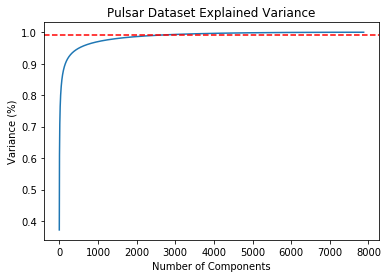

2464


/Users/daniehao/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score :34.12%
              precision    recall  f1-score   support

           0       0.93      0.03      0.06       868
           1       0.60      0.00      0.01       888
           2       0.33      1.00      0.50       870

    accuracy                           0.34      2626
   macro avg       0.62      0.34      0.19      2626
weighted avg       0.62      0.34      0.19      2626

[[ 25   0 843]
 [  2   3 883]
 [  0   2 868]]


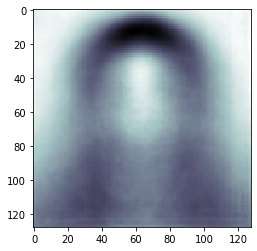

In [35]:
X_train, X_test, y_train, y_test = train_test_split(img_data2d,ages, random_state=1)
from sklearn.decomposition import PCA
#Fitting the PCA algorithm with our Data
pca = PCA(whiten=True, svd_solver='randomized').fit(X_train)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.axhline(y = 0.99, color='r', linestyle='--')
plt.show()
cumpca=np.cumsum(pca.explained_variance_ratio_)
for i in range(len(cumpca)):
    if cumpca[i]>=0.99:
        n_comp=i
        print(i)
        break
from sklearn import decomposition
pca = decomposition.PCA(n_components=n_comp, whiten=True)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
from sklearn import svm
clf = svm.SVC(kernel='poly', class_weight = 'balanced')
clf.fit(X_train_pca, y_train)
plt.imshow(pca.mean_.reshape((128, 128)), cmap=plt.cm.bone)
eigenfaces = pca.components_.reshape((n_comp, 128, 128))
y_pred2 = clf.predict(X_test_pca)
print("Accuracy Score :{0:.2f}%".format(accuracy_score(y_test, y_pred2)*100) )
print(classification_report(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2, labels=range(3)))

In [36]:
from sklearn.metrics import *
print("Accuracy Score :{0:.2f}%".format(accuracy_score(y_test, y_pred2)*100) )
print(classification_report(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2, labels=range(3)))

Accuracy Score :34.12%
              precision    recall  f1-score   support

           0       0.93      0.03      0.06       868
           1       0.60      0.00      0.01       888
           2       0.33      1.00      0.50       870

    accuracy                           0.34      2626
   macro avg       0.62      0.34      0.19      2626
weighted avg       0.62      0.34      0.19      2626

[[ 25   0 843]
 [  2   3 883]
 [  0   2 868]]


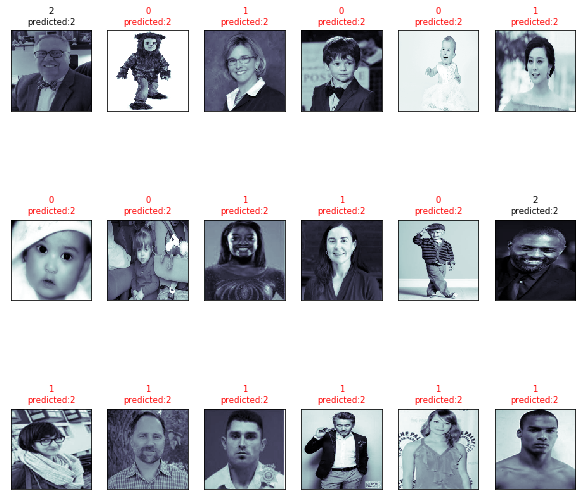

In [37]:
import pylab as pl
fig = plt.figure(figsize=(8, 6))
pl.subplots_adjust(bottom=0, left=.01, right=.99, top=1.20, hspace=.35)
for i in range(18):
    ax = fig.add_subplot(3, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape((128, 128)), cmap=plt.cm.bone)
    color = 'black' if y_pred2[i] == y_test[i] else 'red'
    title = '%s\npredicted:%s' % (y_test[i],y_pred2[i])
    ax.set_title(title, fontsize='small', color=color)

In [45]:
img_data = img_data.reshape((10503,128,128))

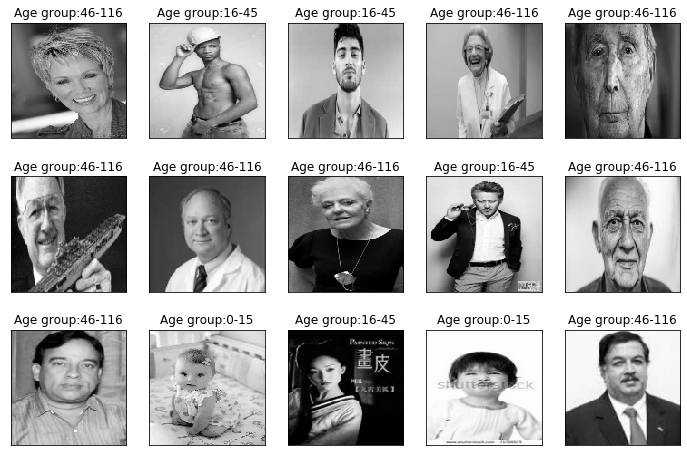

In [47]:
import matplotlib.pyplot as plt

fs = (12, 8)
plt.figure(figsize=fs)
indices = np.random.randint(0, len(img_data)-1, 15)
sample_img = img_data[indices]
sample_age = ages[indices]
sample_group = []
for i in sample_age:
    if i==0:
        sample_group.append("0-15")
    elif i==1:
        sample_group.append("16-45")
    else:
        sample_group.append("46-116")
for i,im in enumerate(sample_img):
    plt.subplot(3, 5, i+1)
    plt.imshow(im, cmap='gray')
    plt.xticks(())
    plt.yticks(())
    plt.title('Age group:' + str(sample_group[i]))
plt.show()